In [2]:
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

## Data Loading

In [3]:
dataset = []

with open("../data/Export All HB-1 Mikrotes 3 09 Nov 24.csv", "r") as f:
    for line in f:
        line = f.readline().split("|")
        if len(line) < 10:
            continue

        signal_trunc = np.array([float(x) for x in line[6:]]) / 65535.0 # 16 bit ADC

        dataset.append({
            "num": int(line[0]),
            "patient_name": line[1].lower().strip(),
            "hb": float(line[5]),
            "signal": signal_trunc,
            "signal_ln_trunc": np.around(np.log(signal_trunc)),
        })

In [4]:
df_gold = pd.read_csv("../data/gold-09-nov.csv").drop(columns=["phone"])
df_gold["name"] = df_gold["name"].str.lower().str.strip()
df_gold.head()

,name,hb_gold
0,shafa mulianti aisyah,12.2
1,saori arsy oktari,12.2
2,fatya adzkiya,13.0
3,eka wulandari,11.9
4,ambarsari as zahra,12.0


## EDA

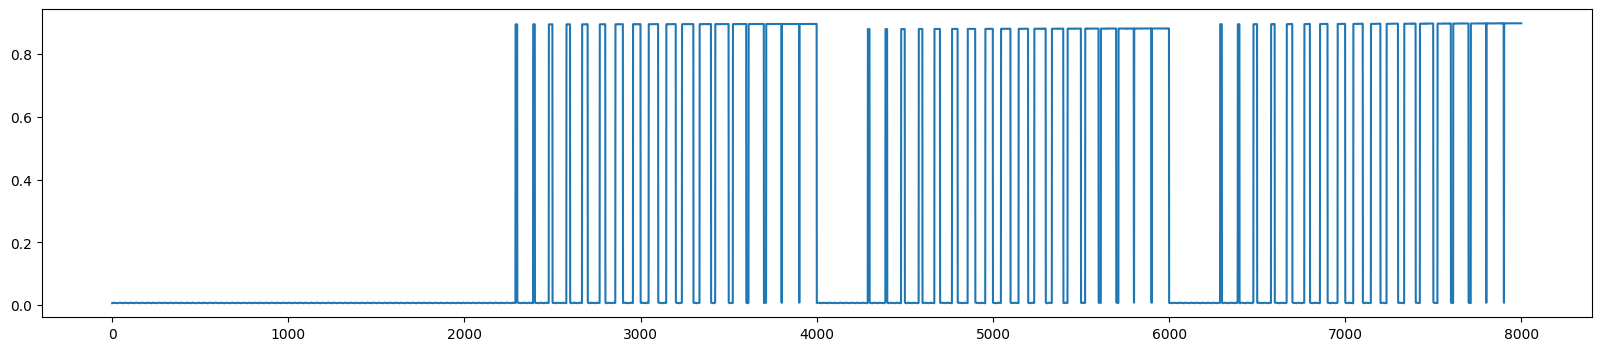

In [5]:
plt.figure(figsize=(20, 4))
plt.plot(dataset[0]["signal"])

## Discrete Fourier Transform

In [6]:
from scipy.fft import fft
from scipy.signal import find_peaks
from scipy.signal.windows import blackman, hamming

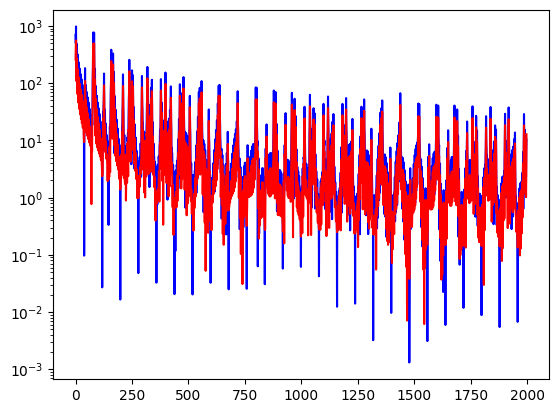

In [7]:
sig = np.array(dataset[0]["signal"])
w = hamming(sig.shape[0])
xw = np.abs(fft(sig * w))[1:sig.shape[0]//2]
xx = np.abs(fft(sig))[1:sig.shape[0]//2]

plt.semilogy(xx[1:xx.shape[0]//2], '-b')
plt.semilogy(xw[1:xw.shape[0]//2], '-r')

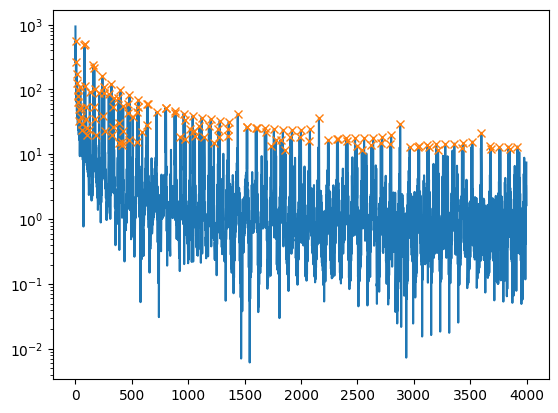

In [8]:
peaks, properties = find_peaks(xw, prominence=11)
plt.semilogy(xw)
plt.semilogy(peaks, xw[peaks], "x")
plt.semilogy(np.zeros_like(xw), "--", color="gray")
plt.show()

In [ ]:
# idx = np.argwhere(dataset[0]["signal_ln_trunc"] > -4)
# sig = dataset[0]["signal"][idx[idx <= 4000]]
# sig = dataset[0]["signal"][idx[(idx > 4000) & (idx < 6000)]]
# sig = dataset[0]["signal"][idx[idx >= 6000]]
# plt.plot(sig)

## Preprocessing

In [9]:
def derive_signal_features_fft(ds: list[dict]):
    derive_ds = []

    # process each row
    for proc in ds:
        # perform DFT
        sig = np.array(proc["signal"])
        sig_fft = np.abs(fft(sig))[1:sig.shape[0]//2]

        # peaks, _ = find_peaks(xw, prominence=20)

        # calculate signal statistics
        derive_ds.append({
            "patient_name": proc["patient_name"].lower().strip(),
            "hb": proc["hb"],
            
            # time domain
            "mean": np.mean(sig),
            "var": np.var(sig),
            "std": np.std(sig),
            "rms": np.sqrt(np.mean(sig ** 2)),
            "power": np.mean(sig ** 2),

            # frequency domain
            # "fft_peaks": len(peaks),
            "fft_mean": np.mean(sig_fft),
            "fft_std": np.std(sig_fft),
            "fft_var": np.var(sig_fft),
        })

    return pd.DataFrame(derive_ds)

In [10]:
def derive_signal_features_stats_v2(ds: list[dict]):
    derive_ds = []

    # process each row
    for proc in ds:
        idx = np.argwhere(proc["signal_ln_trunc"] > -4)
        signal_1 = proc["signal"][idx[idx <= 4000]]
        signal_2 = proc["signal"][idx[(idx > 4000) & (idx < 6000)]]
        signal_3 = proc["signal"][idx[idx >= 6000]]

        # calculate signal statistics
        derive_ds.append({
            "patient_name": proc["patient_name"].lower().strip(),
            "hb": proc["hb"],
            
            "mean_1": np.mean(signal_1),
            "std_1": np.std(signal_1),
            "var_1": np.var(signal_1),
            # "rms_1": np.sqrt(np.mean(signal_1 ** 2)),
            # "power_1": np.mean(signal_1 ** 2),

            "mean_2": np.mean(signal_2),
            "std_2": np.std(signal_2),
            "var_2": np.var(signal_2),
            # "rms_2": np.sqrt(np.mean(signal_2 ** 2)),
            # "power_2": np.mean(signal_2 ** 2),

            "mean_3": np.mean(signal_3),
            "std_3": np.std(signal_3),
            "var_3": np.var(signal_3),
            # "rms_3": np.sqrt(np.mean(signal_3 ** 2)),
            # "power_3": np.mean(signal_3 ** 2),
        })

    return pd.DataFrame(derive_ds)

In [11]:
df_signal = derive_signal_features_fft(dataset)
df_signal.head()

,patient_name,hb,mean,var,std,rms,power,fft_mean,fft_std,fft_var
0,saori arsy oktari,14.00634,0.329389,0.180746,0.425143,0.537814,0.289244,8.614329,37.041472,1372.070633
1,eka wulandari,13.52960,0.328258,0.179475,0.423644,0.535936,0.287228,8.584026,36.910906,1362.414990
2,wan maharani humaira,14.03767,0.328446,0.179663,0.423867,0.536228,0.287540,8.589179,36.930164,1363.837010
3,hana ulil azmi,13.99216,0.325929,0.176897,0.420591,0.532096,0.283127,8.522365,36.644795,1342.840994
4,onyx maxentia,13.99216,0.326178,0.177163,0.420907,0.532499,0.283555,8.529299,36.672273,1344.855608


In [12]:
df_all = df_signal.merge(df_gold, left_on="patient_name", right_on="name")
df_all.head()

,patient_name,hb,mean,var,std,rms,power,fft_mean,fft_std,fft_var,name,hb_gold
0,saori arsy oktari,14.00634,0.329389,0.180746,0.425143,0.537814,0.289244,8.614329,37.041472,1372.070633,saori arsy oktari,12.2
1,eka wulandari,13.52960,0.328258,0.179475,0.423644,0.535936,0.287228,8.584026,36.910906,1362.414990,eka wulandari,11.9
2,wan maharani humaira,14.03767,0.328446,0.179663,0.423867,0.536228,0.287540,8.589179,36.930164,1363.837010,wan maharani humaira,13.9
3,hana ulil azmi,13.99216,0.325929,0.176897,0.420591,0.532096,0.283127,8.522365,36.644795,1342.840994,hana ulil azmi,12.7
4,onyx maxentia,13.99216,0.326178,0.177163,0.420907,0.532499,0.283555,8.529299,36.672273,1344.855608,onyx maxentia,13.5


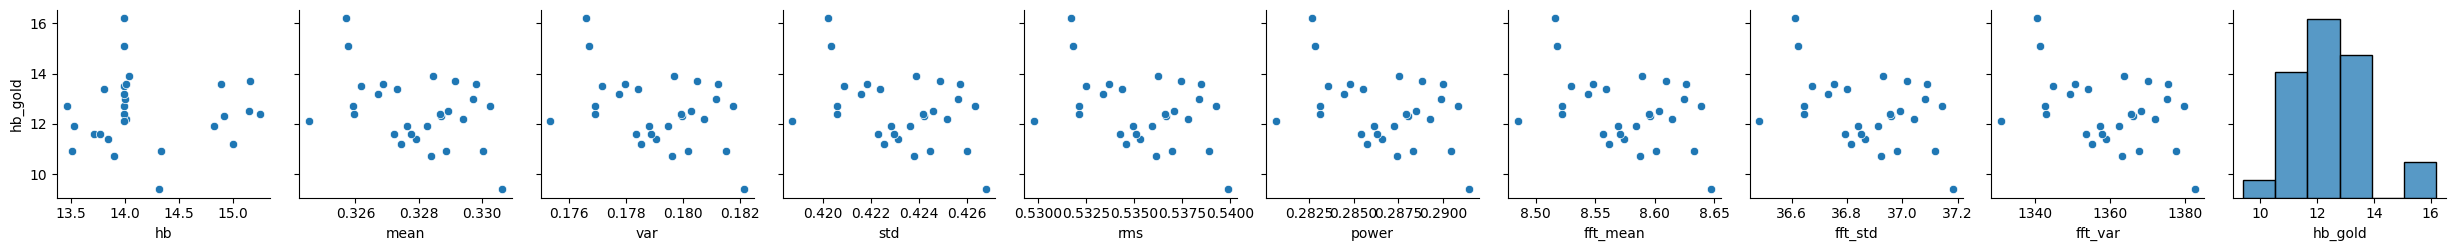

In [13]:
# sns.pairplot(df_all, y_vars=["hb_gold"], x_vars=["avg_seg_0", "avg_seg_1", "std_seg_0", "std_seg_1"])
sns.pairplot(df_all, y_vars=["hb_gold"])

<Axes: >

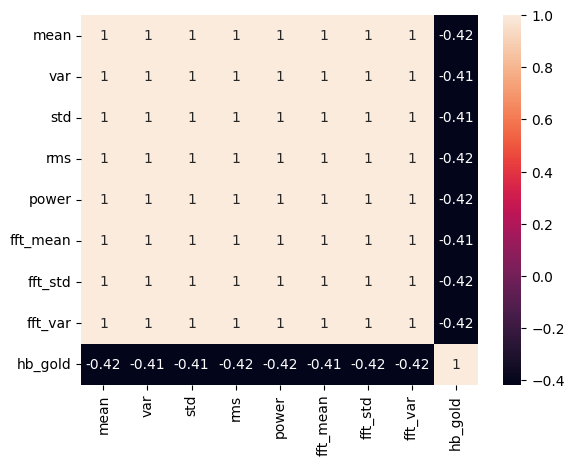

In [14]:
dd = df_all.drop(columns=["patient_name", "name", "hb"], errors="ignore")
sns.heatmap(dd.corr(), annot=True)

## Regressor

In [15]:
# get X, y
X = df_all.drop(columns=["patient_name", "name", "hb", "hb_gold"], errors="ignore")
y = df_all["hb_gold"]

### Cross-Validation

In [16]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, r_regression
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [26]:
scores = cross_validate(LinearRegression(), X, y, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error"])
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.007533,0.003080,-2.415578,-1.400837,-2.618610,-1.618212
1,0.001782,0.002731,-0.405171,-1.193186,-1.918840,-1.385222
2,0.002114,0.002675,-0.994400,-1.120612,-2.858640,-1.690751
3,0.001788,0.002706,-1.235929,-1.110651,-1.243177,-1.114978
4,0.003060,0.003886,-1.511068,-2.310000,-9.698749,-3.114281


In [27]:
scores_df.mean()

fit_time                            0.003255
score_time                          0.003015
test_r2                            -1.312429
test_neg_mean_absolute_error       -1.427057
test_neg_mean_squared_error        -3.667603
test_neg_root_mean_squared_error   -1.784689
dtype: float64

### Hold-out

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
# reg = RandomForestRegressor(random_state=24)
reg = DecisionTreeRegressor()
# reg = LinearRegression()
reg.fit(X_train, y_train)

DecisionTreeRegressor()

<Axes: xlabel='hb_gold'>

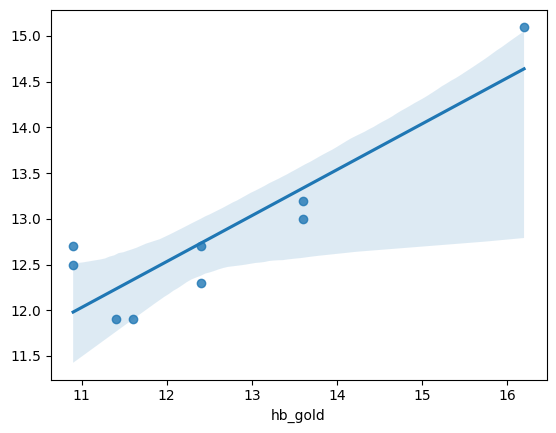

In [20]:
y_pred = reg.predict(X_test)
sns.regplot(x=y_test, y=y_pred)

In [21]:
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.6570895879147147
MAE: 0.7444444444444441
MSE: 0.8855555555555549
RMSE: 0.9410396142328732


## Top-K Feature Selection

In [22]:
reg_pipe = Pipeline(
    [
        ("reduce_dim", SelectKBest(r_regression, k=5)),
        ("classify", DecisionTreeRegressor()),
    ]
)

scores = cross_validate(reg_pipe, X, y, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error"])
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.003974,0.004369,-2.319565,-1.250000,-2.545000,-1.595306
1,0.003628,0.003246,-0.498779,-1.300000,-2.046667,-1.430618
2,0.003024,0.002997,-0.882558,-1.116667,-2.698333,-1.642660
3,0.004110,0.002112,-6.061151,-1.300000,-3.926000,-1.981414
4,0.002465,0.001922,-0.763152,-2.500000,-6.810000,-2.609598


In [23]:
scores_df.mean()

fit_time                            0.003440
score_time                          0.002929
test_r2                            -2.105041
test_neg_mean_absolute_error       -1.493333
test_neg_mean_squared_error        -3.605200
test_neg_root_mean_squared_error   -1.851919
dtype: float64